In [3]:
import numpy as np
from numpy import pi
from ssid import okid, ExtractModes
from control.matlab import ss
from control.matlab import impulse as _impulse
def impulse(*args, **kwds):
    a,t = _impulse(*args, **kwds)
    return a.squeeze(),t 
from scipy import signal
from scipy.signal import dimpulse as _dimpulse
def dimpulse(*args, **kwds):
    t,a = _dimpulse(*args, **kwds)
    return [ai.squeeze() for ai in a],t 
from matplotlib import pyplot as plt
from collections import defaultdict


# Real Time History Data

In [4]:
# See the real response data to test

import pickle
from datetime import datetime
from CE58658.utilities import husid

with open('../../CalTrans.Hayward/Studies/rawRHs.dat', 'rb') as f:
    rawRHs = pickle.load(f)

def plotSensorRH(rawRHs, event_date, channel_numbers, dt, windowed=False):   
    event = rawRHs[event_date]

    accel_unit_label = r"$\ddot{u}$ [g]"
    accel_scale = 1/980.665
    displ_unit_label = r"$u$ [in]"
    displ_scale = 1/2.54

    fig, ax = plt.subplots(len(channel_numbers), 2, figsize=(12,1.75*len(channel_numbers)), constrained_layout=True)
    if dt is not None:
        x_units = "s"
    else:
        dt = 1.0
        x_units = "timestep"
    sensorRH0 = event['24']['accel']*accel_scale
    times = dt*np.arange(len(sensorRH0))
    if windowed:
        window = husid(sensorRH0, False, dt, lb=0.025, ub=0.975)
        times = times[window[0]:window[1]]
    else:
        window = [0,len(sensorRH0)]
        fig, ax = plt.subplots(1,2,figsize=(15,3))

    accels = defaultdict(dict)
    for i,nm in enumerate(channel_numbers):
        accel_series = event[nm]['accel'][window[0]:window[1]]*accel_scale
        accels[nm] = event[nm]['accel']*accel_scale
        displ_series = event[nm]['displ'][window[0]:window[1]]*displ_scale
        direction = event[nm]['direction']
        channel_name = event[nm]['channel_name']
        ax[i,0].plot(times, accel_series, linewidth=0.75)
        ax[i,0].set_ylabel(f"{accel_unit_label}")
        ax[i,0].set_title(f"Channel {nm} ({channel_name}) ({direction})")
        ax[i,1].plot(times, displ_series, linewidth=0.75)
        ax[i,1].set_ylabel(f"{displ_unit_label}")
        ax[i,1].set_title(f"Channel {nm} ({channel_name}) ({direction})")
    ax[-1,0].set_xlabel(f"time [{x_units}]")
    ax[-1,1].set_xlabel(f"time [{x_units}]")
    fig.suptitle(f"Response History of {datetime.strptime(event_date, '%Y-%m-%dT%H:%M:%S')}")
    fig.align_labels()
    plt.show()
    return accels

def getSensorRH(rawRHs, event_date, channel_numbers):   
    event = rawRHs[event_date]
    accel_scale = 1/980.665
    accels = defaultdict(dict)
    for nm in channel_numbers:
        accels[nm] = event[nm]['accel']*accel_scale
    return accels

CHANNELS = {
# channel node dof rotationangle locationname
    "1": (1031, 3, 37.66*pi/180, "abutment_1"),
    "2": (1031, 2, 37.66*pi/180, "abutment_1"),
    "3": (1031, 1, 37.66*pi/180, "abutment_1"),
    "6": (307, 1, 31.02*pi/180, "bent_3_south_column_grnd_level"),
    "7": (307, 2, 31.02*pi/180, "bent_3_south_column_grnd_level"),
    "11": (1030, 3, 37.66*pi/180, "deck_level_near_abut_1"),
    "12": (1030, 1, 37.66*pi/180, "deck_level_near_abut_1"),
    "13": (1030, 2, 37.66*pi/180, "deck_level_near_abut_1"),
    "14": (304, 1, 31.02*pi/180, "bent_3_deck_level"),
    "15": (304, 2, 31.02*pi/180, "bent_3_deck_level"),
    # "16": (30003, 3, ((31.02+26.26)/2)*pi/180, "midspan_between_bents_3_4_deck"),
    "17": (401, 1, 26.26*pi/180, "bent_4_north_column_grnd_level"),
    "18": (401, 2, 26.26*pi/180, "bent_4_north_column_grnd_level"),
    "19": (402, 1, 26.26*pi/180, "bent_4_north_column_top"),
    "20": (402, 2, 26.26*pi/180, "bent_4_north_column_top"),
    "21": (405, 3, 26.26*pi/180, "bent_4_deck_level"),
    "22": (405, 1, 26.26*pi/180, "bent_4_deck_level"),
    "23": (405, 2, 26.26*pi/180, "bent_4_deck_level"),
    "24": (407, 1, 26.26*pi/180, "bent_4_south_column_grnd_level"),
    "25": (407, 2, 26.26*pi/180, "bent_4_south_column_grnd_level")
}

NODE_INFO = {
# key is node number, value is ((ch1,ch2,ch3), location name, rotation angle).
    '1031':  ((3,2,1),        'abutment_1',                      -37.66*pi/180),
    '1030':  ((12,13,11),     'deck_level_near_abut_1',          -37.66*pi/180),
    '304':   ((14,15,None),   'bent_3_deck_level',               -31.02*pi/180),
    '307':   ((6,7,None),     'bent_3_south_column_grnd_level',  -31.02*pi/180),
    '30003': ((None,None,16), 'midspan_between_bents_3_4_deck',  -((31.02+26.26)/2)*pi/180), 
    '401':   ((17,18,None),   'bent_4_north_column_grnd_level',  -26.26*pi/180),
    '402':   ((19,20,None),   'bent_4_north_column_top',         -26.26*pi/180),
    '405':   ((22,23,None),   'bent_4_deck_level',               -26.26*pi/180),
    '407':   ((24,25,None),   'bent_4_south_column_grnd_level',  -26.26*pi/180)
}

channel_numbers = CHANNELS.keys()
channel_numbers = ['12', '13', '14', '15', '18', '19', '20', '22', '23']
output_channel_numbers = ['12', '13', '14', '15', '19', '20', '22', '23']

# event_dates = ['2021-06-24T00:15:00', '2021-06-29T01:29:00', '2021-07-23T15:59:00', '2021-08-03T19:52:00']
full_event_dates = ['2022-02-16T01:46:00', '2022-02-16T05:05:00', '2022-02-16T14:20:00', '2022-02-16T15:50:00', '2021-10-11T16:22:00', '2022-02-16T00:08:00', '2022-02-16T06:09:00', '2022-02-16T08:35:00', '2022-02-16T09:36:00', '2022-02-16T12:58:00', '2022-02-16T14:05:00', '2022-02-16T15:39:00', '2022-02-16T15:56:00', '2022-02-16T17:57:00', '2022-03-01T15:29:00', '2022-04-05T23:10:00', '2022-06-07T14:22:00', '2022-12-28T19:52:00', '2023-01-30T17:55:00', '2021-10-20T19:01:00', '2022-02-16T16:03:00', '2022-03-15T18:12:00', '2022-04-14T14:26:00', '2022-06-14T18:35:00', '2023-02-01T18:22:00', '2021-05-18T20:38:00', '2022-03-17T01:13:00', '2022-05-25T19:45:00', '2022-06-20T16:12:00', '2021-10-29T22:43:00', '2022-03-18T18:46:00', '2022-07-07T20:31:00', '2021-10-07T18:51:00', '2021-11-03T16:28:00', '2022-07-25T19:09:00', '2021-11-05T19:07:00', '2022-08-15T01:55:00', '2021-04-26T17:09:00', '2022-09-06T19:28:00', '2021-11-17T02:00:00', '2022-09-12T10:26:00', '2021-11-17T19:43:00', '2022-09-27T21:49:00', '2022-01-17T15:38:00', '2022-01-24T19:12:00', '2022-11-04T18:31:00', '2022-02-07T00:01:00', '2022-02-12T03:13:00', '2022-02-15T20:01:00', '2022-12-13T21:40:00', '2021-05-12T16:31:00', '2021-06-24T00:15:00', '2021-06-29T01:29:00', '2021-10-02T19:22:00', '2021-07-23T15:59:00', '2021-10-05T19:19:00', '2021-08-03T19:52:00', '2021-08-03T23:45:00', '2021-08-19T15:30:00', '2021-11-05T22:20:00', '2021-04-30T16:40:00']
accelRHs = defaultdict(dict)
for event_date in full_event_dates:
    accelRHs[event_date] = getSensorRH(rawRHs, event_date, channel_numbers)

# Dataset for each event for each channel combination for each model order

In [5]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df

n_events = 1
n_combo = 10
n_channels = 8
n_time = 20

for e in range(n_events):
    data = np.arange(n_channels*n_time).reshape(n_time, n_channels).T

    for i in range(1,n_combo):
        bin_i = bin(i)
        str_i = str(bin_i)[2:]
        lst_i = list(map(int,str_i))
        idx_i = np.array([0]*(n_channels-len(lst_i)) + lst_i, dtype=bool)

        # print(bin_i)
        # print(str_i)
        # print(lst_i)
        print(idx_i)

[False False False False False False False  True]
[False False False False False False  True False]
[False False False False False False  True  True]
[False False False False False  True False False]
[False False False False False  True False  True]
[False False False False False  True  True False]
[False False False False False  True  True  True]
[False False False False  True False False False]
[False False False False  True False False  True]


In [6]:
print(len(full_event_dates))

61


In [7]:
dt = 0.01
q = 1 # number of input channels
n_modes = 3 # number of modes to get periods for
n_channels = len(output_channel_numbers) # total number of channels
event_dates = full_event_dates[30:] 
n_events = len(event_dates)
n_combo = 256
model_orders = [10, 20, 50]
n_orders = len(model_orders)
periods = np.empty((n_events, n_combo, n_orders, n_modes))

import time
timer_0 = time.perf_counter()
for i_event, event_date in enumerate(event_dates):
    inputRH = accelRHs[event_date]['18']
    window = husid(inputRH, False, dt, lb=0.025, ub=0.9)
    eventRHs = np.array([accelRHs[event_date][ch][window[0]:window[1]] for ch in output_channel_numbers])[:,None]
    for i in range(1,n_combo):
        bin_i = bin(i)
        str_i = str(bin_i)[2:]
        lst_i = list(map(int,str_i))
        idx_i = np.array([0]*(n_channels-len(lst_i)) + lst_i, dtype=bool)
        # print(bin_i)
        # print(str_i)
        # print(lst_i)
        # print(idx_i)
        outputRHarray = eventRHs[idx_i]
        # print(outputRHarray.shape)
        p = len(np.arange(n_channels)[idx_i]) # number of output channels
        for i_r, r in enumerate(model_orders):
            mco = min(300,int(np.floor((outputRHarray.shape[2]-1)/2))) # m_o = m_c = (nt-1)/2
            # print(mco)
            Ar,Br,Cr,Dr,HSVs = okid.era(outputRHarray,mco,mco,p,q,r)
            modes = ExtractModes.modes(dt, Ar, Cr)
            period_i = np.array([1/f for f in sorted([modes[str(i)]['freq'] for i in list(modes.keys())])[:n_modes]])
            periods[i_event, i, i_r, :] = period_i
            print(period_i)
time_to_run = time.perf_counter() - timer_0
print(time_to_run)
# with open('periods30-61.dat', 'wb') as f:
#     pickle.dump(periods, f)

[1.68008974 0.80733916 0.56254532]
[1.68041844 0.80981822 0.56586879]
[1.7162502  0.8242751  0.56326874]
[0.16055897 0.15975047 0.11752042]
[1.1628154  0.16072878 0.15104039]
[1.04377123 0.30269506 0.27450111]
[0.99426777 0.65803985 0.1600255 ]
[1.70815785 0.81418102 0.58138237]
[1.68084418 1.00812965 0.80493871]
[1.08990096 0.79199854 0.16255336]
[1.65524816 0.76850943 0.58163421]
[1.70232335 0.81439107 0.57703433]
[1.16498712 0.75004593 0.16198193]
[1.6815174  0.80214048 0.57547993]
[1.70513385 0.81179511 0.5696148 ]
[0.77778161 0.16040062 0.13798686]
[1.06545831 0.77814207 0.17371289]
[1.66517663 1.04348722 0.79920827]
[1.0843217  0.73871595 0.15989285]
[1.64519489 0.80575529 0.58196428]
[1.69346922 0.98855184 0.80651834]
[0.56055157 0.16379108 0.14539244]
[0.61547247 0.53211167 0.16442871]
[1.07477884 0.84443027 0.5714296 ]
[0.56295225 0.16924127 0.14532227]


KeyboardInterrupt: 

In [8]:
print(np.array(periods).shape)

(31, 256, 3, 3)


# Modal Identification from Time History Experiments

In [9]:
full_periods = np.empty((0,256,3,3))
for periodsfile in ['0-5', '6-11', '12-17', '18-23', '24-29', '30-61']:
    with open(f'periods{periodsfile}.dat', 'rb') as f:
        periods = pickle.load(f)
    full_periods = np.concatenate((full_periods,periods))
print(full_periods.shape)

with open('periods_allevents.dat', 'wb') as f:
    pickle.dump(full_periods, f)

(61, 256, 3, 3)


In [10]:
print(len(full_event_dates))

61


In [11]:
import plotly.graph_objects as go

with open('periods_allevents.dat', 'rb') as f:
    full_periods = pickle.load(f)

opsperiods = np.loadtxt("./hwd_ops_impulse/PeriodsPostG.txt")
cgsperiods = full_periods[:,255,0,:]
print(cgsperiods.shape)
n_events = cgsperiods.shape[0]

cgsdf = pd.concat((df(full_event_dates),df(cgsperiods)), axis=1)
cgsdf.columns = ["date", "mode 1", "mode 2", "mode 3"]
cgsdf.sort_values(by=["date"], inplace=True)
cgsdf.head()

fig = go.Figure()
fig.add_scatter(x=cgsdf["date"], y=cgsdf["mode 1"], mode='markers', line_color='#4287f5', opacity=0.7, name='era')
fig.add_scatter(x=cgsdf["date"], y=cgsdf["mode 2"], mode='markers', line_color='#4287f5', opacity=0.7, name='era', showlegend=False)
fig.add_scatter(x=cgsdf["date"], y=cgsdf["mode 3"], mode='markers', line_color='#4287f5', opacity=0.7, name='era', showlegend=False)
fig.add_scatter(x=cgsdf["date"], y=opsperiods[0]*np.ones(n_events), line_color='#616161', line_width=0.5, opacity=0.5, name='numerically predicted')
for i in np.arange(1,8):
    fig.add_scatter(x=cgsdf["date"], y=opsperiods[i]*np.ones(n_events), line_color='#616161', line_width=0.5, opacity=0.5, name='numerically predicted', showlegend=False)
fig.update_layout(title='Predicted Periods Over Time',
                   xaxis_title='date',
                   yaxis_title='period (s)',
                   margin=dict(l=70, r=20, t=50, b=20),
                   width=900,height=400,
                   legend=dict(x=0.05,y=0.9))
fig.show()

(61, 3)


In [12]:
cgsdf["date"]

37    2021-04-26T17:09:00
60    2021-04-30T16:40:00
50    2021-05-12T16:31:00
25    2021-05-18T20:38:00
51    2021-06-24T00:15:00
             ...         
45    2022-11-04T18:31:00
49    2022-12-13T21:40:00
17    2022-12-28T19:52:00
18    2023-01-30T17:55:00
24    2023-02-01T18:22:00
Name: date, Length: 61, dtype: object

In [13]:
import plotly.graph_objects as go

with open('periods_allevents.dat', 'rb') as f:
    full_periods = pickle.load(f)

opsperiods = np.loadtxt("./hwd_ops_impulse/PeriodsPostG.txt")
cgsperiods = full_periods[:,35,0,:]
print(cgsperiods.shape)
n_events = cgsperiods.shape[0]

cgsdf = pd.concat((df(full_event_dates),df(cgsperiods)), axis=1)
cgsdf.columns = ["date", "mode 1", "mode 2", "mode 3"]
cgsdf.sort_values(by=["date"], inplace=True)
cgsdf = cgsdf[cgsdf["date"]!=("2022-12-13T21:40:00")]
cgsdf.head()

fig = go.Figure()
fig.add_scatter(x=cgsdf["date"], y=cgsdf["mode 1"], mode='markers', line_color='#4287f5', opacity=0.7, name='ERA')
fig.add_scatter(x=cgsdf["date"], y=cgsdf["mode 2"], mode='markers', line_color='#4287f5', opacity=0.7, name='ERA', showlegend=False)
fig.add_scatter(x=cgsdf["date"], y=cgsdf["mode 3"], mode='markers', line_color='#4287f5', opacity=0.7, name='ERA', showlegend=False)
fig.add_scatter(x=cgsdf["date"], y=opsperiods[0]*np.ones(n_events), line_color='#616161', line_width=0.5, opacity=0.5, name='numerically predicted')
for i in np.arange(1,8):
    fig.add_scatter(x=cgsdf["date"], y=opsperiods[i]*np.ones(n_events), line_color='#616161', line_width=0.5, opacity=0.5, name='numerically predicted', showlegend=False)
fig.update_layout(title='Predicted Periods Over Time',
                   xaxis_title='date',
                   yaxis_title='period (s)',
                   margin=dict(l=70, r=20, t=50, b=20),
                   width=900,height=400,
                   legend=dict(x=0.75,y=0.9))
fig.show()

(61, 3)


(array([28., 23., 34.,  7.,  1.,  1.,  5.,  4.,  1.,  3.,  4.,  4.,  3.,
        15.,  6., 17.,  1.,  0.,  3.,  0.,  0.,  2., 12.,  3.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([0.04088343, 0.08889293, 0.13690242, 0.18491191, 0.23292141,
        0.2809309 , 0.32894039, 0.37694989, 0.42495938, 0.47296887,
        0.52097837, 0.56898786, 0.61699736, 0.66500685, 0.71301634,
        0.76102584, 0.80903533, 0.85704482, 0.90505432, 0.95306381,
        1.0010733 , 1.0490828 , 1.09709229, 1.14510179, 1.19311128,
        1.24112077, 1.28913027, 1.33713976, 1.38514925, 1.43315875,
        1.48116824, 1.52917773, 1.57718723, 1.62519672, 1.67320621,
        1.72121571, 1.7692252 , 1.8172347 , 1.86524419, 1.91325368,
        1.96126318]),
 <BarContainer object of 40 artists>)

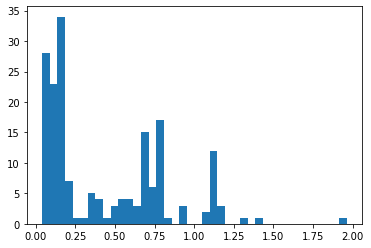

In [14]:
plt.hist(np.array([cgsdf["mode 1"], cgsdf["mode 2"], cgsdf["mode 3"]]).flatten(), bins = 40)

(array([ 8.,  2.,  4.,  2.,  0.,  0.,  0.,  3.,  0.,  1.,  1.,  1.,  0.,
         5.,  2.,  9.,  0.,  0.,  2.,  0.,  0.,  2., 12.,  3.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([0.04379916, 0.09173576, 0.13967236, 0.18760896, 0.23554556,
        0.28348216, 0.33141876, 0.37935536, 0.42729196, 0.47522856,
        0.52316516, 0.57110177, 0.61903837, 0.66697497, 0.71491157,
        0.76284817, 0.81078477, 0.85872137, 0.90665797, 0.95459457,
        1.00253117, 1.05046777, 1.09840437, 1.14634097, 1.19427757,
        1.24221417, 1.29015077, 1.33808737, 1.38602397, 1.43396057,
        1.48189717, 1.52983377, 1.57777037, 1.62570697, 1.67364357,
        1.72158017, 1.76951677, 1.81745338, 1.86538998, 1.91332658,
        1.96126318]),
 <BarContainer object of 40 artists>)

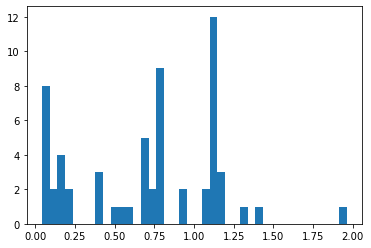

In [15]:
plt.hist(np.array([cgsdf["mode 1"]]).flatten(), bins = 40)

(array([4., 5., 1., 3., 6., 7., 2., 1., 0., 0., 0., 0., 1., 2., 0., 0., 1.,
        0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 3., 5., 3., 1., 2., 4., 3.,
        0., 0., 0., 0., 0., 1.]),
 array([0.04173869, 0.0644509 , 0.08716311, 0.10987532, 0.13258753,
        0.15529974, 0.17801194, 0.20072415, 0.22343636, 0.24614857,
        0.26886078, 0.29157298, 0.31428519, 0.3369974 , 0.35970961,
        0.38242182, 0.40513402, 0.42784623, 0.45055844, 0.47327065,
        0.49598286, 0.51869507, 0.54140727, 0.56411948, 0.58683169,
        0.6095439 , 0.63225611, 0.65496831, 0.67768052, 0.70039273,
        0.72310494, 0.74581715, 0.76852936, 0.79124156, 0.81395377,
        0.83666598, 0.85937819, 0.8820904 , 0.9048026 , 0.92751481,
        0.95022702]),
 <BarContainer object of 40 artists>)

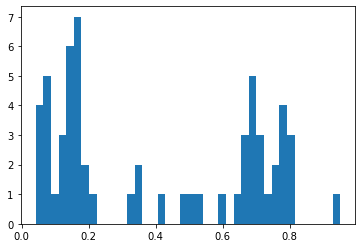

In [16]:
plt.hist(np.array([cgsdf["mode 2"]]).flatten(), bins = 40)

(array([ 2.,  8.,  3.,  1., 11.,  5., 13.,  1.,  2.,  1.,  0.,  0.,  1.,
         1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  2.,  0.,  0.,
         1.]),
 array([0.04088343, 0.05940564, 0.07792784, 0.09645004, 0.11497224,
        0.13349445, 0.15201665, 0.17053885, 0.18906106, 0.20758326,
        0.22610546, 0.24462766, 0.26314987, 0.28167207, 0.30019427,
        0.31871648, 0.33723868, 0.35576088, 0.37428308, 0.39280529,
        0.41132749, 0.42984969, 0.4483719 , 0.4668941 , 0.4854163 ,
        0.5039385 , 0.52246071, 0.54098291, 0.55950511, 0.57802732,
        0.59654952, 0.61507172, 0.63359392, 0.65211613, 0.67063833,
        0.68916053, 0.70768274, 0.72620494, 0.74472714, 0.76324934,
        0.78177155]),
 <BarContainer object of 40 artists>)

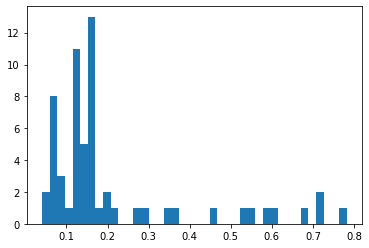

In [17]:
plt.hist(np.array([cgsdf["mode 3"]]).flatten(), bins = 40)